In [ ]:
# %pip install -U --quiet  langgraph langchain_openai
# %pip install -U --quiet tavily-python
# %pip install -qU langchain-text-splitters
# %pip install -qU langchain-community

In [1]:
overall_prompt = """You are a AI assistant with a background in drug discovery.

    Given target: Gamma secretase
    Given disease: Alzheimer's disease
    Given mode of action: Gamma secretase is a multi-subunit protease complex that cleaves type I transmembrane proteins, including the amyloid precursor protein (APP) leading to the generation of amyloid-beta (Aβ) peptides.

    Context:
     Aβ is a family of secreted peptides generated from the sequential cleavages of the type 1 membrane protein APP by beta-secretase (BACE) and gamma-secretase (GSEC), respectively. 
     BACE cleaves APP in the luminal domain, releasing the N-terminal soluble APPβ domain and leaving the C-terminal fragment, APP-CTF, which remains in the membrane. 
     Subsequently, the APP-CTF is recruited to GSEC, a complex comprising four subunits, including PS, which harbors the active site. 
     GSEC first cuts APP-CTF at the epsilon-cleavage site located close to the inner leaflet of the membrane. This cleavage event produces either Aβ48 or Aβ49 and the APP intracellular domain (AICD).
    The membrane-retained Aβ48 or Aβ49 is then further processed by GSEC in a continuous cascade of proteolytical events at every third of fourth amino acid, where the N-terminal product of each reaction becomes the substrate for the next GSEC cleavage event. 
    Accordingly, GSEC processes APP-CTF along two main product lines, Aβ49 → 46 → 43 → 40 → 37… and Aβ48 → 45 → 42 → 38…, respectively. During this processing cascade, Aβ43 and shorter Aβ peptides stochastically escape further processing by GSEC and are released into the extracellular space. As a result, Aβ peptides varying from 30 to 43 amino acids in length are secreted into the extracellular space. Among all secreted Aβ, Aβ40 is the most abundant in human CSF, followed by Aβ38, Aβ42, and Aβ37 (Liu et al., 2022). In cognitively normal individuals, Aβ42 and Aβ43 represent a smaller portion of the total secreted Aβ (Liu et al., 2022). These longer forms of Aβ seed the formation of Aβ-amyloid aggregates, a key step in the formation of amyloid plaques (Veugelen et al., 2016), as illustrated in Figure 1. Aβ42, which is produced in higher amounts than Aβ43, is the most abundant Aβ in amyloid plaques (Welander et al., 2009).


    Task 1: Develop a scientific rationale for Gamma secretase in Alzheimer's disease.

    Highlight the working hypothesis for the clinical target rationale and human biology evidence by minimum 2000 words.

    Describe as much as possible the evidence in humans or in human tissue that link the target, target space or approach to the pathogenesis of interest.
    If known, also describe here the wanted mode of action with regards to desired clinical outcome.
    Please avoid including only pre-clinical data in this section.

    Use the following structure and provide a detailed description for each point:
    - Working hypothesis:
    - Create a detailed description of the following idea: Develop an inhibitor of the neurokinin 3 receptor (NK3R) GPCR for the treatment of vasomotor symptoms due to menopause.
    - Is there are significant unmet medical need?
    - Is it suitable for combination therapy?
    - Which predictive biomarkers exist for the target related to the disease?
        - Provide a detailed description of existing clinical relevant biomarkers.

    - Clinical target rationale:
    - How relevant is the target location to the disease biology?
    - How it the target expression altered in human disease?
    - How is the target involved in the physiological process relevant to the disease?
    - Which phenotypes and genotypes were identified for the target?
    - How is the genetic link between the target and the disease?
    - Describe the evidence provided in clinics or by tools acting on the pathway where the target is involved.
    - Which kind of target modulation is required to treat the disease?

    - Challenges for the drug discovery program related to the target.
    - Check the following idea for details on small molecule compounds: Develop an inhibitor of the neurokinin 3 receptor (NK3R) GPCR for the treatment of vasomotor symptoms due to menopause..
    - Is a 'information driven approach' (IDA) strategy based on available small molecules possible?
        - Which small molecular modulators of the target known?
        - Which inhibitors, antagonists, agonists, negative allosteric modulators (NAM), positive allosteric modulators (PAM) are required for target modulation in the given disease? 
    - Which patients would respond the therapy?
    - Is the proposed mode of action on the target desirable and commercially viable in a clinical setting?
    - What are advantages and disadvantages of different therapeutic modalities (antibodies, small molecules, antisense oligonucleotides, PROTACs, molecular glue, peptide macrocycles, and so on) for tackling the target?

    - Alternative indications:
    - Describe alternative indication for modulators of the target and explain why.

    Task 2: Develop a target assessment strategy for Gamma secretase in Alzheimer's disease in maximal 500 words.

    Outline a 1-year Target Assessment (TA) to Lead Identification (LI) plan. Describe High Level TA-LI plans.
    - Make an emphasis on key inflection points that will inform the feasibility of the project. 
    - Address status of in-vitro platforms, translational in vivo models (mechanistic models, not necessarily so called 'disease models')
    and describe what needs to be established. Elaborate on tractability and major challenges for advancement in a drug discovery portfolio.
    - Discuss potential biomarkers and readouts for efficacy and target engagement.

    Task 3: Safety assessment
    - Does the target show bias towards expression in the desired organ (e.g. CNS)?
    - Is it specifically expressed in the organ (e.g. brain)?
    - Are there disease specific expression databases?
    - Are there tissue-selective isoforms of the target?
    - Are there condition-specific isoforms of the target?
    - What regulates the alternative splicing that makes one isoform versus the other?
    - How large is the expression of the target in the mouse model intended for in vivo tests?
    - Is major phenotype reported in target knockouts and/or expression of rodent models?
    - Are there published differences in expression between human and rodent models.
    - What are the species differences that could be used to interpret rodent safety data on the target?
    - What are the peripherial safety risks (oncogensis)?
    - Can the modulation of the target promote tumor formation?
    - Is there a way to assess on-target safety concerns?
    - What are the safety concerns in case of exaggerated pharmacology?
    - Will it disrupt cellular functions (e.g. endosomes, lysosomes, nuclear, mitochondrial) function with all its safety liability?
    - How large is the risk for immunogenicity (related to biologics/antibody based approaches)?
    - If the target is an enzyme, do polymorphisms in the human gene alter the protein enzyme activity?

    Provide the corresponding literature references in the format (First author, Journal, Year, Volume, Issue, Pages, DOI). If any are missing or not available, please mark as N/A."""

In [2]:
chat_prompt = "You are ChatGPT, a large language model trained by OpenAI, based on the GPT-4 architecture and you cite the papers you use in your answers using Harvard Style."

working_hypothesis_prompt = """ 
# Scientific Rationale for Gamma Secretase in Alzheimer's Disease


## Target Information 
### Develop a scientific rationale for the following:
                             
    **Given target:** Gamma secretase
    **Given disease:** Alzheimer's disease
    **Given mode of action:** Gamma secretase is a multi-subunit protease complex that cleaves type I transmembrane proteins, including the amyloid precursor protein (APP) leading to the generation of amyloid-beta (Aβ) peptides.

##Context:
Aβ is a family of secreted peptides generated from the sequential cleavages of the type 1 membrane protein APP by beta-secretase (BACE) and gamma-secretase (GSEC), respectively. 
BACE cleaves APP in the luminal domain, releasing the N-terminal soluble APPβ domain and leaving the C-terminal fragment, APP-CTF, which remains in the membrane. 
Subsequently, the APP-CTF is recruited to GSEC, a complex comprising four subunits, including PS, which harbors the active site. GSEC first cuts APP-CTF at the epsilon-cleavage site located close to the inner leaflet of the membrane. 
This cleavage event produces either Aβ48 or Aβ49 and the APP intracellular domain (AICD). The membrane-retained Aβ48 or Aβ49 is then further processed by GSEC in a continuous cascade of proteolytical events at every third of fourth amino acid, where the N-terminal product of each reaction becomes the substrate for the next GSEC cleavage event.
Accordingly, GSEC processes APP-CTF along two main product lines, Aβ49 → 46 → 43 → 40 → 37… and Aβ48 → 45 → 42 → 38…, respectively. During this processing cascade, Aβ43 and shorter Aβ peptides stochastically escape further processing by GSEC and are released into the extracellular space. 
As a result, Aβ peptides varying from 30 to 43 amino acids in length are secreted into the extracellular space. Among all secreted Aβ, Aβ40 is the most abundant in human CSF, followed by Aβ38, Aβ42, and Aβ37. In cognitively normal individuals, Aβ42 and Aβ43 represent a smaller portion of the total secreted Aβ.
These longer forms of Aβ seed the formation of Aβ-amyloid aggregates, a key step in the formation of amyloid plaques (Veugelen et al., 2016), as illustrated in Figure 1. Aβ42, which is produced in higher amounts than Aβ43, is the most abundant Aβ in amyloid plaques (Welander et al., 2009).

## Task 1: Develop Scientific Rationale

### Working Hypothesis
- Detailed description of the idea
- Unmet medical need
- Suitability for combination therapy
- Predictive biomarkers
- Clinical relevance of existing biomarkers


"""

clinical_target_prompt = """ #Clinical Target Rationale for Gamma Secretase in Alzheimer's Disease


## Target Information 
### Develop a scientific rationale for the following:
                             
    **Given target:** Gamma secretase
    **Given disease:** Alzheimer's disease
    **Given mode of action:** Gamma secretase is a multi-subunit protease complex that cleaves type I transmembrane proteins, including the amyloid precursor protein (APP) leading to the generation of amyloid-beta (Aβ) peptides.

##Context:
Aβ is a family of secreted peptides generated from the sequential cleavages of the type 1 membrane protein APP by beta-secretase (BACE) and gamma-secretase (GSEC), respectively. 
BACE cleaves APP in the luminal domain, releasing the N-terminal soluble APPβ domain and leaving the C-terminal fragment, APP-CTF, which remains in the membrane. 
Subsequently, the APP-CTF is recruited to GSEC, a complex comprising four subunits, including PS, which harbors the active site. GSEC first cuts APP-CTF at the epsilon-cleavage site located close to the inner leaflet of the membrane. 
This cleavage event produces either Aβ48 or Aβ49 and the APP intracellular domain (AICD). The membrane-retained Aβ48 or Aβ49 is then further processed by GSEC in a continuous cascade of proteolytical events at every third of fourth amino acid, where the N-terminal product of each reaction becomes the substrate for the next GSEC cleavage event.
Accordingly, GSEC processes APP-CTF along two main product lines, Aβ49 → 46 → 43 → 40 → 37… and Aβ48 → 45 → 42 → 38…, respectively. During this processing cascade, Aβ43 and shorter Aβ peptides stochastically escape further processing by GSEC and are released into the extracellular space. 
As a result, Aβ peptides varying from 30 to 43 amino acids in length are secreted into the extracellular space. Among all secreted Aβ, Aβ40 is the most abundant in human CSF, followed by Aβ38, Aβ42, and Aβ37. In cognitively normal individuals, Aβ42 and Aβ43 represent a smaller portion of the total secreted Aβ.
These longer forms of Aβ seed the formation of Aβ-amyloid aggregates, a key step in the formation of amyloid plaques (Veugelen et al., 2016), as illustrated in Figure 1. Aβ42, which is produced in higher amounts than Aβ43, is the most abundant Aβ in amyloid plaques (Welander et al., 2009).
 

 ### Clinical target rationale:
    - How relevant is the target location to the disease biology?
    - How is the target expression altered in human disease?
    - How is the target involved in the physiological process relevant to the disease?
    - Which phenotypes and genotypes were identified for the target?
    - How is the genetic link between the target and the disease?
    - Describe the evidence provided in clinics or by tools acting on the pathway where the target is involved.
    - Which kind of target modulation is required to treat the disease? """

Challenges_prompt = """ #Challenges for the drug discovery program related to Gamma Secretase as a target in Alzheimer's Disease
    **Given target:** Gamma secretase
    **Given disease:** Alzheimer's disease
    **Given mode of action:** Gamma secretase is a multi-subunit protease complex that cleaves type I transmembrane proteins, including the amyloid precursor protein (APP) leading to the generation of amyloid-beta (Aβ) peptides.

##Context:
Aβ is a family of secreted peptides generated from the sequential cleavages of the type 1 membrane protein APP by beta-secretase (BACE) and gamma-secretase (GSEC), respectively. 
BACE cleaves APP in the luminal domain, releasing the N-terminal soluble APPβ domain and leaving the C-terminal fragment, APP-CTF, which remains in the membrane. 
Subsequently, the APP-CTF is recruited to GSEC, a complex comprising four subunits, including PS, which harbors the active site. GSEC first cuts APP-CTF at the epsilon-cleavage site located close to the inner leaflet of the membrane. 
This cleavage event produces either Aβ48 or Aβ49 and the APP intracellular domain (AICD). The membrane-retained Aβ48 or Aβ49 is then further processed by GSEC in a continuous cascade of proteolytical events at every third of fourth amino acid, where the N-terminal product of each reaction becomes the substrate for the next GSEC cleavage event.
Accordingly, GSEC processes APP-CTF along two main product lines, Aβ49 → 46 → 43 → 40 → 37… and Aβ48 → 45 → 42 → 38…, respectively. During this processing cascade, Aβ43 and shorter Aβ peptides stochastically escape further processing by GSEC and are released into the extracellular space. 
As a result, Aβ peptides varying from 30 to 43 amino acids in length are secreted into the extracellular space. Among all secreted Aβ, Aβ40 is the most abundant in human CSF, followed by Aβ38, Aβ42, and Aβ37. In cognitively normal individuals, Aβ42 and Aβ43 represent a smaller portion of the total secreted Aβ.
These longer forms of Aβ seed the formation of Aβ-amyloid aggregates, a key step in the formation of amyloid plaques (Veugelen et al., 2016), as illustrated in Figure 1. Aβ42, which is produced in higher amounts than Aβ43, is the most abundant Aβ in amyloid plaques (Welander et al., 2009).

### Challenges:
- Check the following idea for details on small molecule compounds: Developing small molecule modulators or inhibitors of gamma secretase for Alzheimer's disease treatment.
- Is a 'information driven approach' (IDA) strategy based on available small molecules possible?
- Which small molecular modulators of the target known?
- Which inhibitors, antagonists, agonists, negative allosteric modulators (NAM), positive allosteric modulators (PAM) are required for target modulation in the given disease? 
- Which patients would respond the therapy?
- Is the proposed mode of action on the target desirable and commercially viable in a clinical setting?
- What are advantages and disadvantages of different therapeutic modalities (antibodies, small molecules, antisense oligonucleotides, PROTACs, molecular glue, peptide macrocycles, and so on) for tackling the target?

- Alternative indications:
- Describe alternative indication for modulators of the target and explain why.


"""


In [3]:
import getpass
import os
from langchain.pydantic_v1 import BaseModel, Field
from langchain.tools import BaseTool, StructuredTool, tool


def _set_if_undefined(var: str) -> None:
    if os.environ.get(var):
        return
    os.environ[var] = getpass.getpass(var)


# Optional: Configure tracing to visualize and debug the agent
_set_if_undefined("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Reflexion_1"

_set_if_undefined("OPENAI_API_KEY")




In [4]:
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.5)

embedding_model = OpenAIEmbeddings()
# You could also use OpenAI or another provider
# from langchain_openai import ChatOpenAI

# llm = ChatOpenAI(model="gpt-4-turbo-preview")

In [5]:
embeddings = embedding_model.embed_documents(
    [
        "Hi there!",
        "Oh, hello!",
        "What's your name?",
        "My friends call me World",
        "Hello World!"
        "wow whats your name and where are you from?"
    ]
)
len(embeddings), len(embeddings[3])

(5, 1536)

In [6]:
from APIs.pubmed import Pubmed_API_langchain
from langchain_text_splitters import RecursiveCharacterTextSplitter
import time
from langchain_chroma import Chroma


text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,  # Increased for more context
    chunk_overlap=100,
    length_function=len,
    is_separator_regex=False,
)
@tool # sometimes the PubmedAPI goes down, so try later.
def get_pubmed_papers_for_llm(query, max_results=1, email="your_email@example.com", sleep_time=3, used_papers=set(), max_chunks=150):
    """
    Retrieve papers from PubMed Central and format them for LLM processing, skipping previously used papers.
    
    Args:
    query (str): The search query for PubMed Central.
    max_results (int): Maximum number of papers to retrieve. Default is 1.
    email (str): Your email address for NCBI's records. Replace with your actual email.
    sleep_time (float): Time to sleep between API requests in seconds. Default is 3.
    used_papers (set): Set of paper IDs that have already been used and should be skipped.
    
    Returns:
    list: List of chunked papers, each containing content and metadata.
    """
    total_chunks = 0

    # embedding_model = OpenAIEmbeddings()

    print("Initializing PMC API")
    pmc_api = Pubmed_API_langchain(email=email)
    
    # Search for papers
    print(f"Searching PMC for: '{query}'")
    papers = pmc_api.query(query, max_results)  # Fetch more papers to account for potential skips
    
    print(f"Retrieved {len(papers)} papers")
    
    chunked_papers = []
    processed_papers = 0
    for i, paper in enumerate(papers):
        if processed_papers >= max_results:
            break
        
        if paper['pmc_id'] in used_papers:
            print(f"Skipping already used paper: {paper['pmc_id']}")
            continue
        
        # Sleep between API requests
        if i > 0:
            time.sleep(sleep_time)
        
        # Combine title, abstract, and full text
        full_content = f"Title: {paper['title']}\n\nAbstract: {paper['abstract']}\n\nFull Text: {paper['full_text']}"
        
        # Split the content into chunks
        chunks = text_splitter.split_text(full_content)

        chunks_to_add = min(len(chunks), max_chunks - total_chunks)

        
 
        # # Embedding for long texts - cant be used for now because of the API and also the looping of the revision - 
        # embedded_chunks = embedding_model.embed_documents(chunks)
        # db = Chroma.from_documents(documents, OpenAIEmbeddings())
        
        # Add metadata to each chunk

        # Add metadata to each chunk
        for j in range(chunks_to_add):
            chunked_papers.append({
                'content': chunks[j],
                'metadata': {
                    'paper_id': paper['pmc_id'],
                    'chunk_id': j,
                    'total_chunks': chunks_to_add,
                    'authors': paper['authors'],
                    'year': paper['year'],
                    'journal': paper['journal']
                }
            })

        used_papers.add(paper['pmc_id'])
        processed_papers += 1
        total_chunks += chunks_to_add
    
    if chunked_papers:
        first_chunk = chunked_papers[0]
        print("\nFirst chunk structure:")
        print(f"Content length: {len(first_chunk['content'])}")
        print(f"Metadata keys: {', '.join(first_chunk['metadata'].keys())}")
    
    return chunked_papers

# Example usage:
# query = "machine learning in healthcare"
# chunked_papers = get_pubmed_papers_for_llm(query, max_results=5, email="your_actual_email@example.com")

In [7]:
from langchain_core.messages import HumanMessage, ToolMessage
from langchain_core.output_parsers.openai_tools import PydanticToolsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.pydantic_v1 import BaseModel, Field, ValidationError


class Reflection(BaseModel):
    missing: str = Field(description="Critique of what is missing.")
    superfluous: str = Field(description="Critique of what is superfluous and could be removed or improved with depth.")


class AnswerQuestion(BaseModel):
    """Answer the question. Provide an answer, reflection, and then follow up with search queries to improve the answer."""
    answer: str = Field(description="You are a AI assistant with a background in drug discovery and specialise in writing scientific rationales for given targets and diseases, you cite your work.")
    reflection: Reflection = Field(description="Your reflection on the initial answer.")
    # best_query: str = Field(description="The best selected search query")
    search_queries: list[str] = Field(
        description="search queries for pubmed for researching improvements to address the critique of your current answer."
    )
    # query_selection_reason: str = Field(description="Reason for selecting the best query")


class ResponderWithRetries:
    def __init__(self, runnable, validator):
        self.runnable = runnable
        self.validator = validator

    def respond(self, state: list):
        response = self.runnable.invoke(
            {"messages": state}, {"tags": ["attempt:0"]}
        )
        try:
            self.validator.invoke(response)
            return response
        except ValidationError as e:
            error_message = self.format_error_message(e)
            state = state + [
                response,
                ToolMessage(
                    content=error_message,
                    tool_call_id=response.tool_calls[0]["id"],
                ),
            ]
        return response

    def format_error_message(self, e):
        # Implement this method to format the error message
        return f"Validation error: {str(e)}"

    def format_error_message(self, error: ValidationError):
        # Extract relevant information from the error
        error_details = error.errors()
        formatted_errors = []
        for detail in error_details:
            field = detail['loc'][0] if detail['loc'] else 'unknown field'
            message = detail['msg']
            formatted_errors.append(f"- {field}: {message}")
        
        error_message = "Your response didn't meet the expected format. Please fix the following issues:\n"
        error_message += "\n".join(formatted_errors)
        error_message += "\n\nPlease provide your response in valid JSON format with the following structure:\n"
        error_message += '{\n  "answer": "Your Markdown-formatted answer here",\n  "references": ["Reference 1", "Reference 2", ...]\n}'
        
        return error_message

In [8]:
import datetime

actor_prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are an expert researcher in target discovery and providing scientific rationales for a given target and disease. You are tasked with developing in depth and scientifically sound
            rationales for different targets and diseases. You must answer in paragraphs and provide detailed explanations for your answers. You must also provide references to support your claims with the proived chunks and meta data in Harvard Style.
Current time: {time}

1. {first_instruction}
2. Reflect and critique your answer. Be severe to maximize improvement.
3. Recommend multiple search queries to research information and improve your answer based on the feedback you receive - 
    The following worked very well for me in the past in terms of generating the highest number of results use it as a guide:
                        ###Example:
                        "Target" AND "Disease" AND ("relevant_keyword" OR "relevant_keyword_1 Or "[relevant_keyword_n") and so on.
                        You should use search notation to improve results. 
                        Your search should be specific to the reflection and critique.
                        ##IMPORTANT:
                        Just provide the query. Do not add any additional information.
                        DO NOT copy the given example
4. Select the best query from your list and provide a reason for your selection.""",
        ),
        MessagesPlaceholder(variable_name="messages"),
        (
            "user",
            "\n\n<system>Reflect on the user's original question and the"
            " actions taken thus far. Respond using the {function_name} function.</reminder>",
        ),
    ]
).partial(
    time=lambda: datetime.datetime.now().isoformat(),
)
initial_answer_chain = actor_prompt_template.partial(
    first_instruction="Provide a detailed essay length answer to the question.",
    function_name=AnswerQuestion.__name__,
) | llm.bind_tools(tools=[AnswerQuestion])
validator = PydanticToolsParser(tools=[AnswerQuestion])

first_responder = ResponderWithRetries(
    runnable=initial_answer_chain, validator=validator
)

In [9]:
initial = first_responder.respond([HumanMessage(content=working_hypothesis_prompt)])

In [10]:
revise_instructions = """Revise your previous answer using the new information.
        - You should use the previous critique to add important information to your answer.
        - You MUST include Harvard style citations in your revised answer to ensure it can be verified.
        - Add a "References" section to the bottom of your answer (which does not count towards the word limit).
        -  author, title, year, journal, DOI, leave empty if not available
    - You should use the previous critique to remove superfluous information and deepen your answer with more relevant content from the sources obtained
"""

# Extend the initial answer schema to include references.
# Forcing citation in the model encourages grounded responses
class ReviseAnswer(AnswerQuestion):
    """Revise your original answer to the question. Provide an answer, reflection,

    cite your reflection with references, and finally
    suggest search queries based on your reflection to improve the answer"""

    references: list[str] = Field(
        description="Citations motivating your updated answer."
    )


revision_chain = actor_prompt_template.partial(
    first_instruction=revise_instructions,
    function_name=ReviseAnswer.__name__,
) | llm.bind_tools(tools=[ReviseAnswer])
revision_validator = PydanticToolsParser(tools=[ReviseAnswer])

revisor = ResponderWithRetries(runnable=revision_chain, validator=revision_validator)

In [11]:
import json

revised = revisor.respond(
    [
        HumanMessage(content=working_hypothesis_prompt),
        initial,
        ToolMessage(
            tool_call_id=initial.tool_calls[0]["id"],
            content=json.dumps(
                get_pubmed_papers_for_llm.invoke(
                    {"query": initial.tool_calls[0]["args"]["search_queries"][0]}
                )
            ),
        ),
    ]
)
revised

Initializing PMC API
Searching PMC for: 'Gamma secretase AND Alzheimer's disease AND (mechanisms OR pathways OR "molecular interactions")'
PMC_API.query called with: Gamma secretase AND Alzheimer's disease AND (mechanisms OR pathways OR "molecular interactions"), 1
Saved paper PMC9076685 to memory
Retrieved 1 papers

First chunk structure:
Content length: 41
Metadata keys: paper_id, chunk_id, total_chunks, authors, year, journal


AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_qdPZRZl7ngR75qW2X4p6frZM', 'function': {'arguments': '{"answer":"### Scientific Rationale for Gamma Secretase in Alzheimer\'s Disease\\n\\n#### Working Hypothesis\\nGamma secretase (GSEC) is a multi-subunit protease complex that plays a crucial role in the pathogenesis of Alzheimer\'s disease (AD) through its involvement in the cleavage of amyloid precursor protein (APP). This cleavage leads to the production of amyloid-beta (Aβ) peptides, particularly the aggregation-prone Aβ42, which is implicated in the formation of amyloid plaques—a hallmark of AD pathology. The hypothesis posits that dysregulation of GSEC activity results in an imbalance favoring the accumulation of toxic Aβ species, contributing to neurodegeneration and cognitive decline (Selkoe, 2011). Targeting GSEC could reduce the production of these harmful peptides and address a central mechanism underlying AD.\\n\\n#### Unmet Medical Need\\nAD affects mil

In [12]:
print(json.dumps(initial.tool_calls[0]["args"], indent=2))

{
  "answer": "### Scientific Rationale for Gamma Secretase in Alzheimer's Disease\n\n#### Working Hypothesis\nGamma secretase (GSEC) plays a pivotal role in the pathophysiology of Alzheimer\u2019s disease (AD) through its involvement in the processing of amyloid precursor protein (APP) to generate amyloid-beta (A\u03b2) peptides. The prevailing hypothesis is that dysregulation of GSEC activity leads to an imbalance in A\u03b2 production, specifically the overproduction of longer, aggregation-prone forms such as A\u03b242, which are critical in the formation of amyloid plaques\u2014a hallmark of AD pathology. This hypothesis is supported by the observation that increased levels of A\u03b242 correlate with cognitive decline and the progression of AD (Selkoe, 2011). Targeting GSEC could thus mitigate the accumulation of these toxic peptides and address a fundamental aspect of AD pathology.\n\n#### Unmet Medical Need\nAlzheimer\u2019s disease currently affects millions worldwide, and ther

In [13]:
from langchain_core.tools import StructuredTool
from langgraph.prebuilt import ToolNode
from itertools import cycle



def run_queries(search_queries: list[str], **kwargs):
    """Run the generated queries."""
    if search_queries:
        return get_pubmed_papers_for_llm.invoke({"query": search_queries[0]})
    else:
        "No search queries provided."

# # def run_queries(response: dict, **kwargs):
# #     """Run the best query selected."""
# #     best_query = response['best_query']
# #     return get_pubmed_papers_for_llm.invoke({"query": best_query})

# def run_queries(response: dict, **kwargs):
#     """Run the best query selected."""

#     print("CP1")
#     best_query = response['best_query']
#     print("CP2")
#     return get_pubmed_papers_for_llm.invoke({"query": best_query})

tool_node = ToolNode(
    [
        StructuredTool.from_function(run_queries, name=AnswerQuestion.__name__),
        StructuredTool.from_function(run_queries, name=ReviseAnswer.__name__),
    ]
)

In [14]:
from typing import Literal

from langgraph.graph import END, MessageGraph, START

MAX_ITERATIONS = 18 # probably far too much 
builder = MessageGraph()
builder.add_node("draft", first_responder.respond)


builder.add_node("Pubmed_Search", tool_node)
builder.add_node("revise", revisor.respond)
# draft -> execute_tools
builder.add_edge("draft", "Pubmed_Search")
# execute_tools -> revise
builder.add_edge("Pubmed_Search", "revise")

# Define looping logic:


def _get_num_iterations(state: list):
    i = 0
    for m in state[::-1]:
        if m.type not in {"tool", "ai"}:
            break
        i += 1
        print(m)
    return i


def event_loop(state: list) -> Literal["Pubmed_Search", "__end__"]:
    # in our case, we'll just stop after N plans
    num_iterations = _get_num_iterations(state)
    if num_iterations > MAX_ITERATIONS:
        return END
    return "Pubmed_Search"


# revise -> execute_tools OR end
builder.add_conditional_edges("revise", event_loop)
builder.add_edge(START, "draft")
graph = builder.compile()

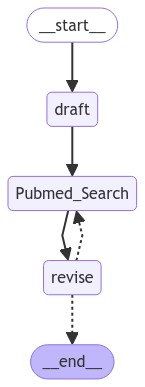

In [15]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [16]:
events = graph.stream(
    [HumanMessage(content=working_hypothesis_prompt)],
    stream_mode="values",)


for i, step in enumerate(events):
    print(f"Step {i}")
    step[-1].pretty_print()

Step 0
================================ Human Message =================================

 
# Scientific Rationale for Gamma Secretase in Alzheimer's Disease


## Target Information 
### Develop a scientific rationale for the following:
                             
    **Given target:** Gamma secretase
    **Given disease:** Alzheimer's disease
    **Given mode of action:** Gamma secretase is a multi-subunit protease complex that cleaves type I transmembrane proteins, including the amyloid precursor protein (APP) leading to the generation of amyloid-beta (Aβ) peptides.

##Context:
Aβ is a family of secreted peptides generated from the sequential cleavages of the type 1 membrane protein APP by beta-secretase (BACE) and gamma-secretase (GSEC), respectively. 
BACE cleaves APP in the luminal domain, releasing the N-terminal soluble APPβ domain and leaving the C-terminal fragment, APP-CTF, which remains in the membrane. 
Subsequently, the APP-CTF is recruited to GSEC, a complex comprising f

KeyboardInterrupt: 

In [ ]:
# limit the number of chunks to 150 to avoid context length in tokens exceeding the limit

